In [1]:
import os
# Cambiar al directorio padre
os.chdir("..")

import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
from src.utils.helpers import load_config

In [2]:
config = load_config()
raw_path= os.path.join(config["paths"]["raw_data"], config["data"]["file_name"])

In [3]:
df = pd.read_csv(raw_path)
df.head()

,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5


# Exploración general

## Resumen de las variables

In [4]:
# 1. Estilo general
plt.style.use("dark_background")  # fondo negro
sns.set_context("notebook", font_scale=1.1)
sns.set_style({"axes.facecolor": "#000000", "figure.facecolor": "#000000"})  # negro puro

# 2. Paleta de azules tecnológicos vibrantes
tech_blues = sns.color_palette([
    "#00FFFF",  # Cyan
    "#00BFFF",  # DeepSkyBlue
    "#1E90FF",  # DodgerBlue
    "#4682B4",  # SteelBlue
    "#5F9EA0",  # CadetBlue
    "#7DF9FF",  # Electric Blue
])

sns.set_palette(tech_blues)

# 3. Fuente blanca
plt.rcParams["text.color"] = "white"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["axes.edgecolor"] = "white"

# 4. Quitar grid y spines innecesarios
sns.set_style({"axes.grid": False})  # quitar grid


# 5. Quitar spines superior e izquierdo por defecto
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

warnings.simplefilter(action='ignore', category=FutureWarning)

class DataFrameSummarizer():
    def __init__(self, df, tech_blues=tech_blues):
        self.df = df
        self.numeric_columns = df.select_dtypes(include=[np.number]).columns
        self.tech_blues = tech_blues

    def _is_numeric(self, col):
        return col in self.numeric_columns

    def _get_numeric_stats(self, col):
        series = self.df[col]
        quantiles = series.quantile([0, 0.25, 0.5, 0.75, 1.0])
        quantiles.index = ['min', '0.25', 'median', '0.75', 'max']
        mean = series.mean()
        std = series.std()
        return mean, std, quantiles

    def _count_outliers_iqr(self, col, factor=1.5):
        series = self.df[col]
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        return len(outliers)

    def _plot_distribution(self, col, max_unique_cat=10):
        series = self.df[col]

        plt.figure(figsize=(8, 4))
        unique_vals = series.nunique(dropna=True)

        if self._is_numeric(col) and unique_vals > max_unique_cat:
            sns.histplot(series.dropna(), bins=30, kde=True)
            plt.title(f"Histograma de {series.name}")
        else:
            counts = series.value_counts(dropna=False)
            #repeated_palette = (tech_blue_palette * ((counts // len(tech_blue_palette)) + 1))[:len(df)]
            sns.countplot(x=series, order=counts.index[:max_unique_cat], palette=self.tech_blues)
            plt.title(f"Frecuencias de {series.name}")
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def _summarize_column(self, col, outlier_iqr_factor=1.5, max_unique_cat=20):
        df = self.df.copy()
        print(f"Columna: {col}")
        print("-" * 40)

        series = df[col]
        total = series.shape[0]
        missing = series.isna().sum()
        print(f"Total registros: {total}")
        print(f"Valores perdidos: {missing}")

        unique_vals = series.nunique(dropna=True)

        if self._is_numeric(col) and unique_vals > max_unique_cat:
            mean, std, quantiles = self._get_numeric_stats(col)
            outliers = self._count_outliers_iqr(col, outlier_iqr_factor)

            print(f"Media: {mean:.3f}")
            print(f"Desviación estándar: {std:.3f}")
            print("Quantiles:")
            print(quantiles)
            print(f"Número de outliers (IQR {outlier_iqr_factor}x): {outliers}")
        else:
            print(f"Número de valores únicos: {unique_vals}")
            print("Frecuencias:")
            print(series.value_counts(dropna=False).head(10))

        self._plot_distribution(col, max_unique_cat=max_unique_cat)
        print("\n\n")

    def run_summarize(self):
        for col in self.df.columns:
            self._summarize_column(col)

Columna: Home ID
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Media: 250.375
Desviación estándar: 144.435
Quantiles:
min         1.0
0.25      125.0
median    250.0
0.75      375.0
max       500.0
Name: Home ID, dtype: float64
Número de outliers (IQR 1.5x): 0


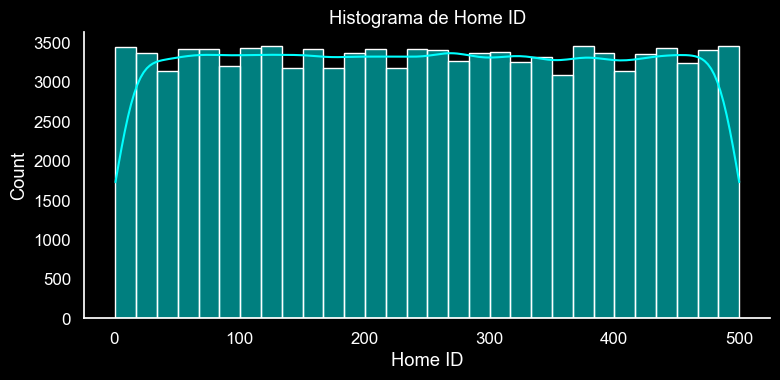




Columna: Appliance Type
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Número de valores únicos: 10
Frecuencias:
Appliance Type
Lights              10201
Dishwasher          10095
Air Conditioning    10067
Heater              10018
Washing Machine      9953
Microwave            9947
Computer             9944
Oven                 9939
Fridge               9931
TV                   9905
Name: count, dtype: int64


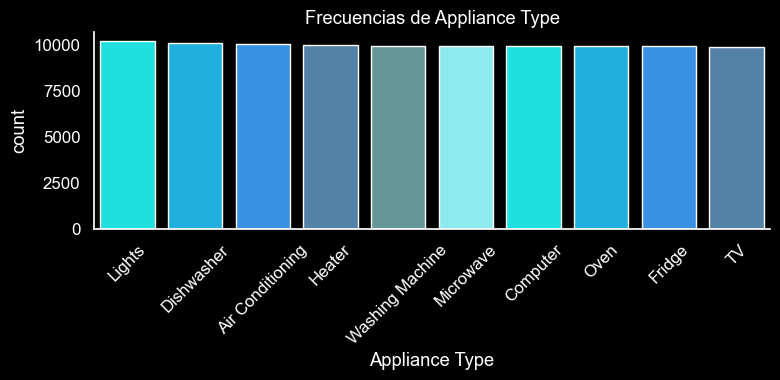




Columna: Energy Consumption (kWh)
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Media: 1.500
Desviación estándar: 1.181
Quantiles:
min       0.10
0.25      0.59
median    1.23
0.75      1.87
max       5.00
Name: Energy Consumption (kWh), dtype: float64
Número de outliers (IQR 1.5x): 7997


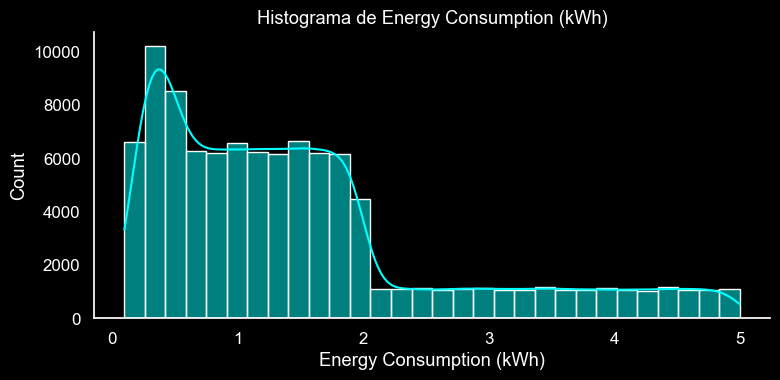




Columna: Time
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Número de valores únicos: 1440
Frecuencias:
Time
02:44    98
07:04    94
15:26    94
17:34    93
23:19    93
05:18    92
04:13    92
16:42    91
23:13    91
15:44    91
Name: count, dtype: int64


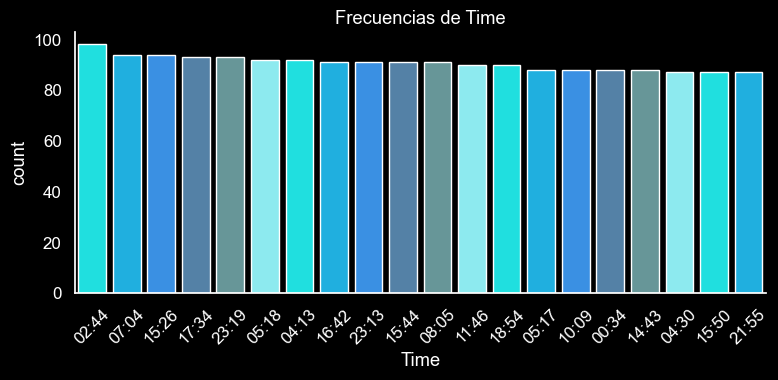




Columna: Date
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Número de valores únicos: 366
Frecuencias:
Date
2023-10-08    326
2023-02-09    320
2023-07-18    316
2023-09-17    313
2023-07-15    309
2023-05-16    305
2023-06-11    305
2023-04-12    304
2023-02-16    304
2023-11-02    304
Name: count, dtype: int64


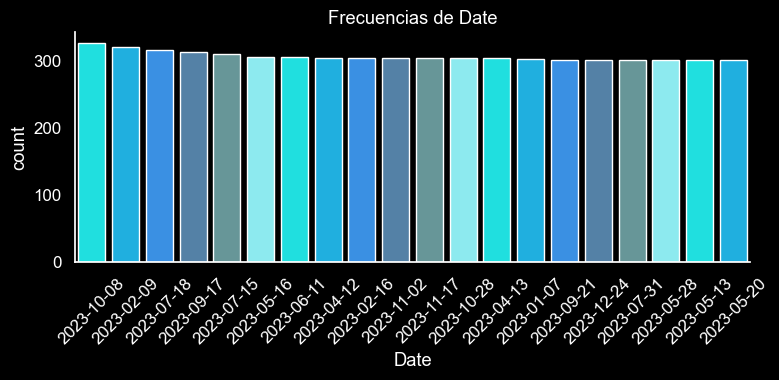




Columna: Outdoor Temperature (°C)
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Media: 14.950
Desviación estándar: 14.439
Quantiles:
min      -10.0
0.25       2.4
median    14.9
0.75      27.4
max       40.0
Name: Outdoor Temperature (°C), dtype: float64
Número de outliers (IQR 1.5x): 0


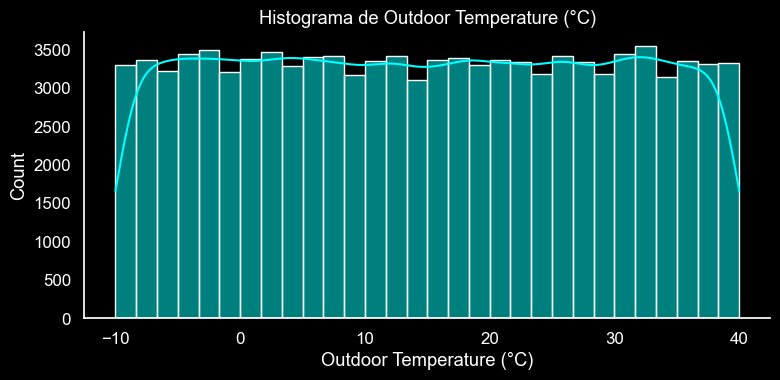




Columna: Season
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Número de valores únicos: 4
Frecuencias:
Season
Spring    25112
Fall      25026
Summer    24966
Winter    24896
Name: count, dtype: int64


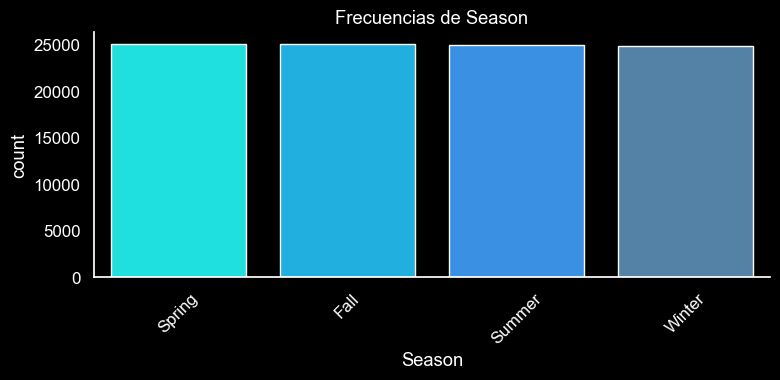




Columna: Household Size
----------------------------------------
Total registros: 100000
Valores perdidos: 0
Número de valores únicos: 5
Frecuencias:
Household Size
1    20175
5    20099
4    20021
3    20013
2    19692
Name: count, dtype: int64


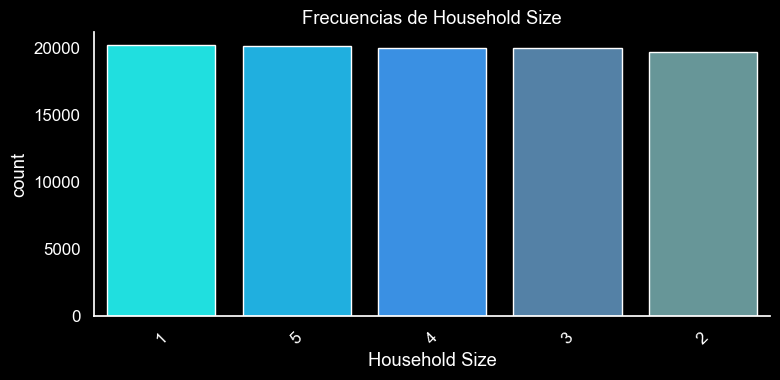

In [5]:
summarizer = DataFrameSummarizer(df)
summarizer.run_summarize()

## Limpieza Básica y conversión de tipos

In [6]:
# Limpieza nombre de las variable
df.columns = (
    df.columns
    .str.strip()         # quitar espacios al inicio/final
    .str.lower()         # pasar a minúsculas
    .str.replace(" ", "_")  # reemplazar espacios por _
)
df.head()

,home_id,appliance_type,energy_consumption_(kwh),time,date,outdoor_temperature_(°c),season,household_size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5


In [7]:
# Convertir fecha y hora
df["datetime"] = pd.to_datetime(df["date"] + ' ' + df["time"], errors='coerce')
df.drop(columns=["date", "time"], inplace=True)

In [8]:
# Convertir season a valores numéricos
season_map = {
    "Summer": 3,
    "Spring": 2,
    "Fall": 1,
    "Winter": 0
}

df["season"] = df["season"].map(season_map)

### Análisis temporal

In [9]:
df["hour"] = df["datetime"].dt.hour               # Hora del día (0-23)
df["weekday"] = df["datetime"].dt.dayofweek       # Día de la semana (0-6)
df["day"] = df["datetime"].dt.day                 # Día del mes (1–31)
df["month"] = df["datetime"].dt.month             # Mes del año (1-12)
df["is_weekend"] = df["weekday"].isin([5, 6])

def show_catplot(d, x="hour", y="energy_consumption_(kwh)", col="appliance_type", kind="box",
                 title="Consumo energético por hora del día, por tipo de electrodoméstico"):
    data = d.copy()
    data = data.sort_values(by="datetime")
    # Boxplot por hora, separado por tipo de electrodoméstico
    g = sns.catplot(
        x=x,
        y=y,
        col=col,                       # separa por columna (puedes usar row= también)
        data=data,
        kind=kind,
        palette=tech_blues,            # tu paleta personalizada
        col_wrap=3,                    # número de gráficos por fila
        height=4,                      # tamaño del gráfico
        aspect=1.2                     # proporción ancho/alto
    )

    plt.subplots_adjust(top=0.9)
    plt.suptitle(title, color="white")
    plt.show()

    correlations = (
    df.groupby(col)
      .apply(lambda g: g[x].corr(g[y]))
    )
    print(correlations)

#### Análisis temporal por electrodoméstico

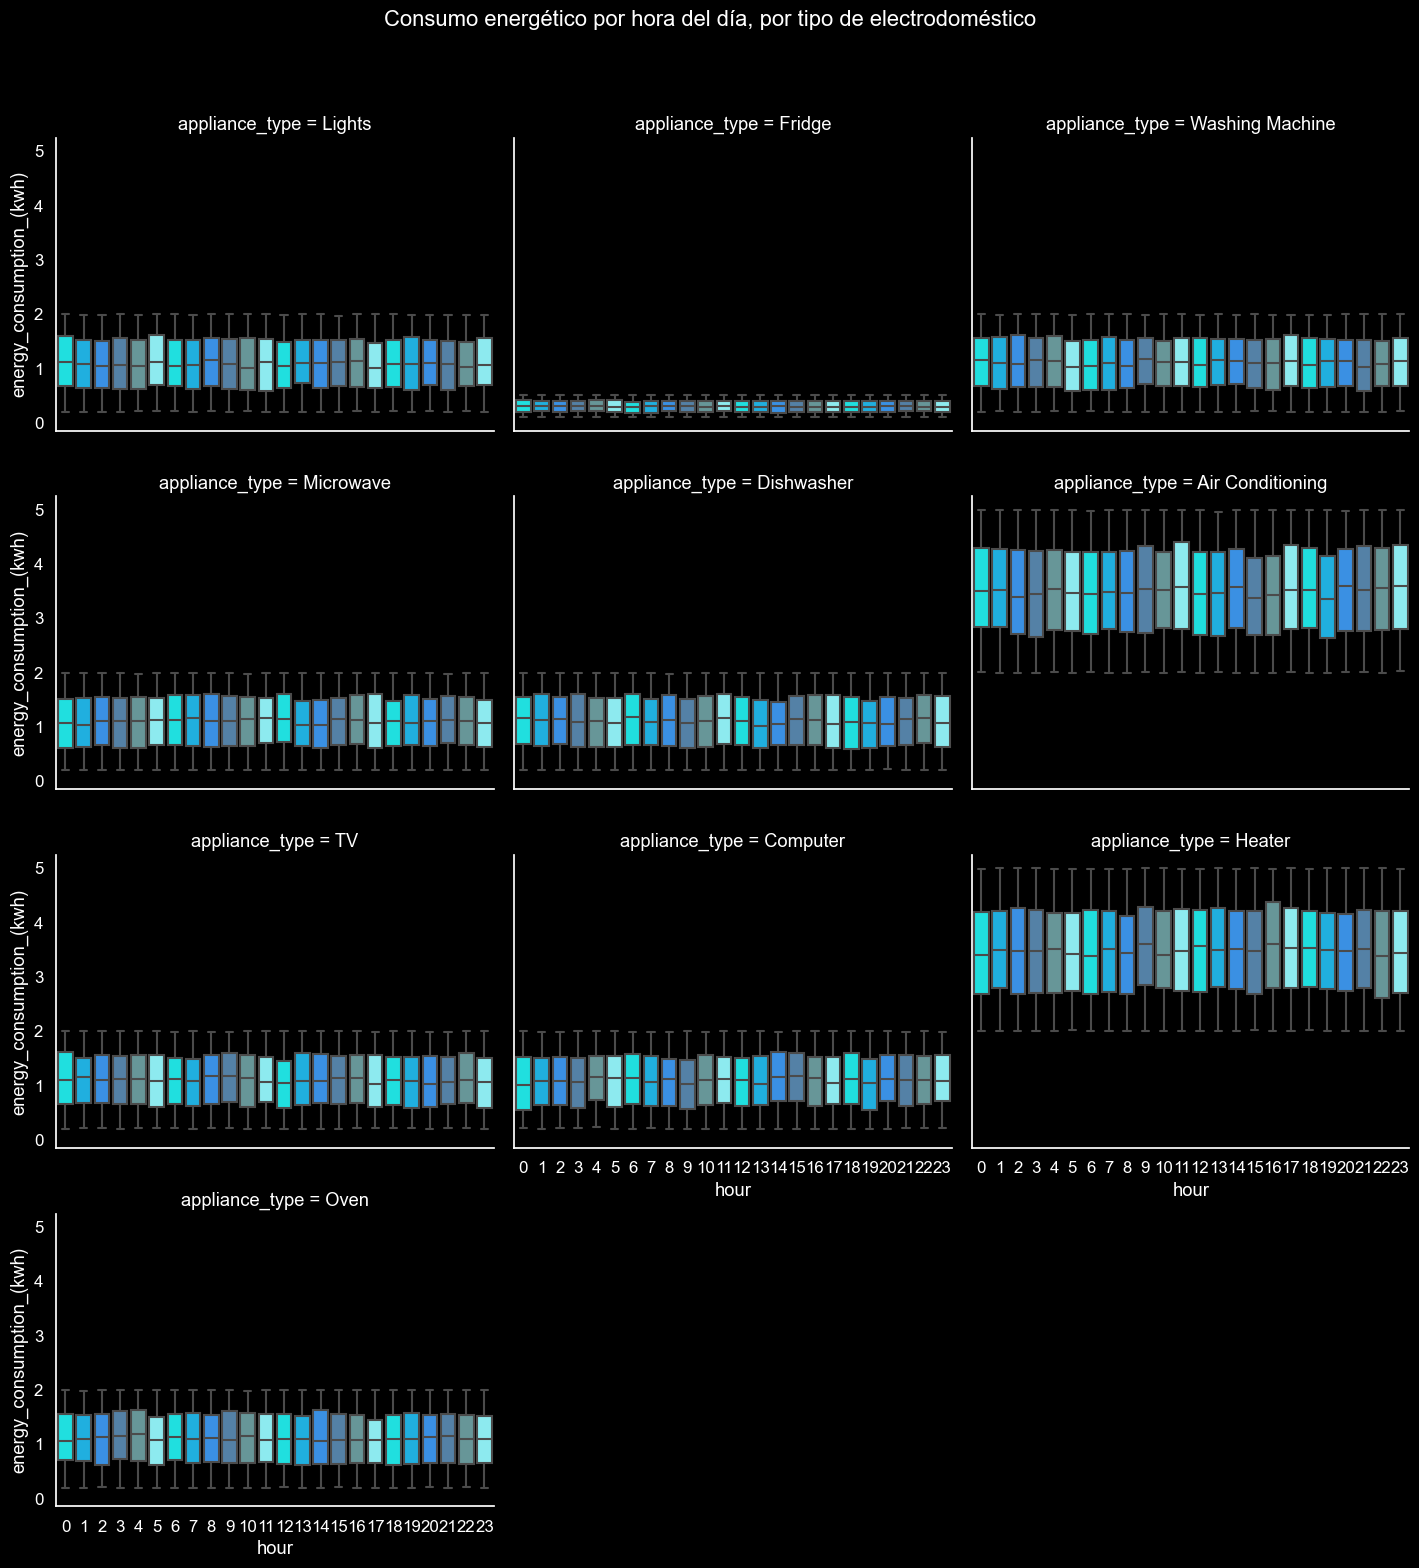

appliance_type
Air Conditioning    0.002123
Computer            0.018639
Dishwasher         -0.008347
Fridge             -0.005544
Heater              0.008037
Lights             -0.005739
Microwave           0.004053
Oven               -0.014536
TV                 -0.016409
Washing Machine    -0.003217
dtype: float64


In [10]:
# Análisis por hora del día
show_catplot(df, x="hour")

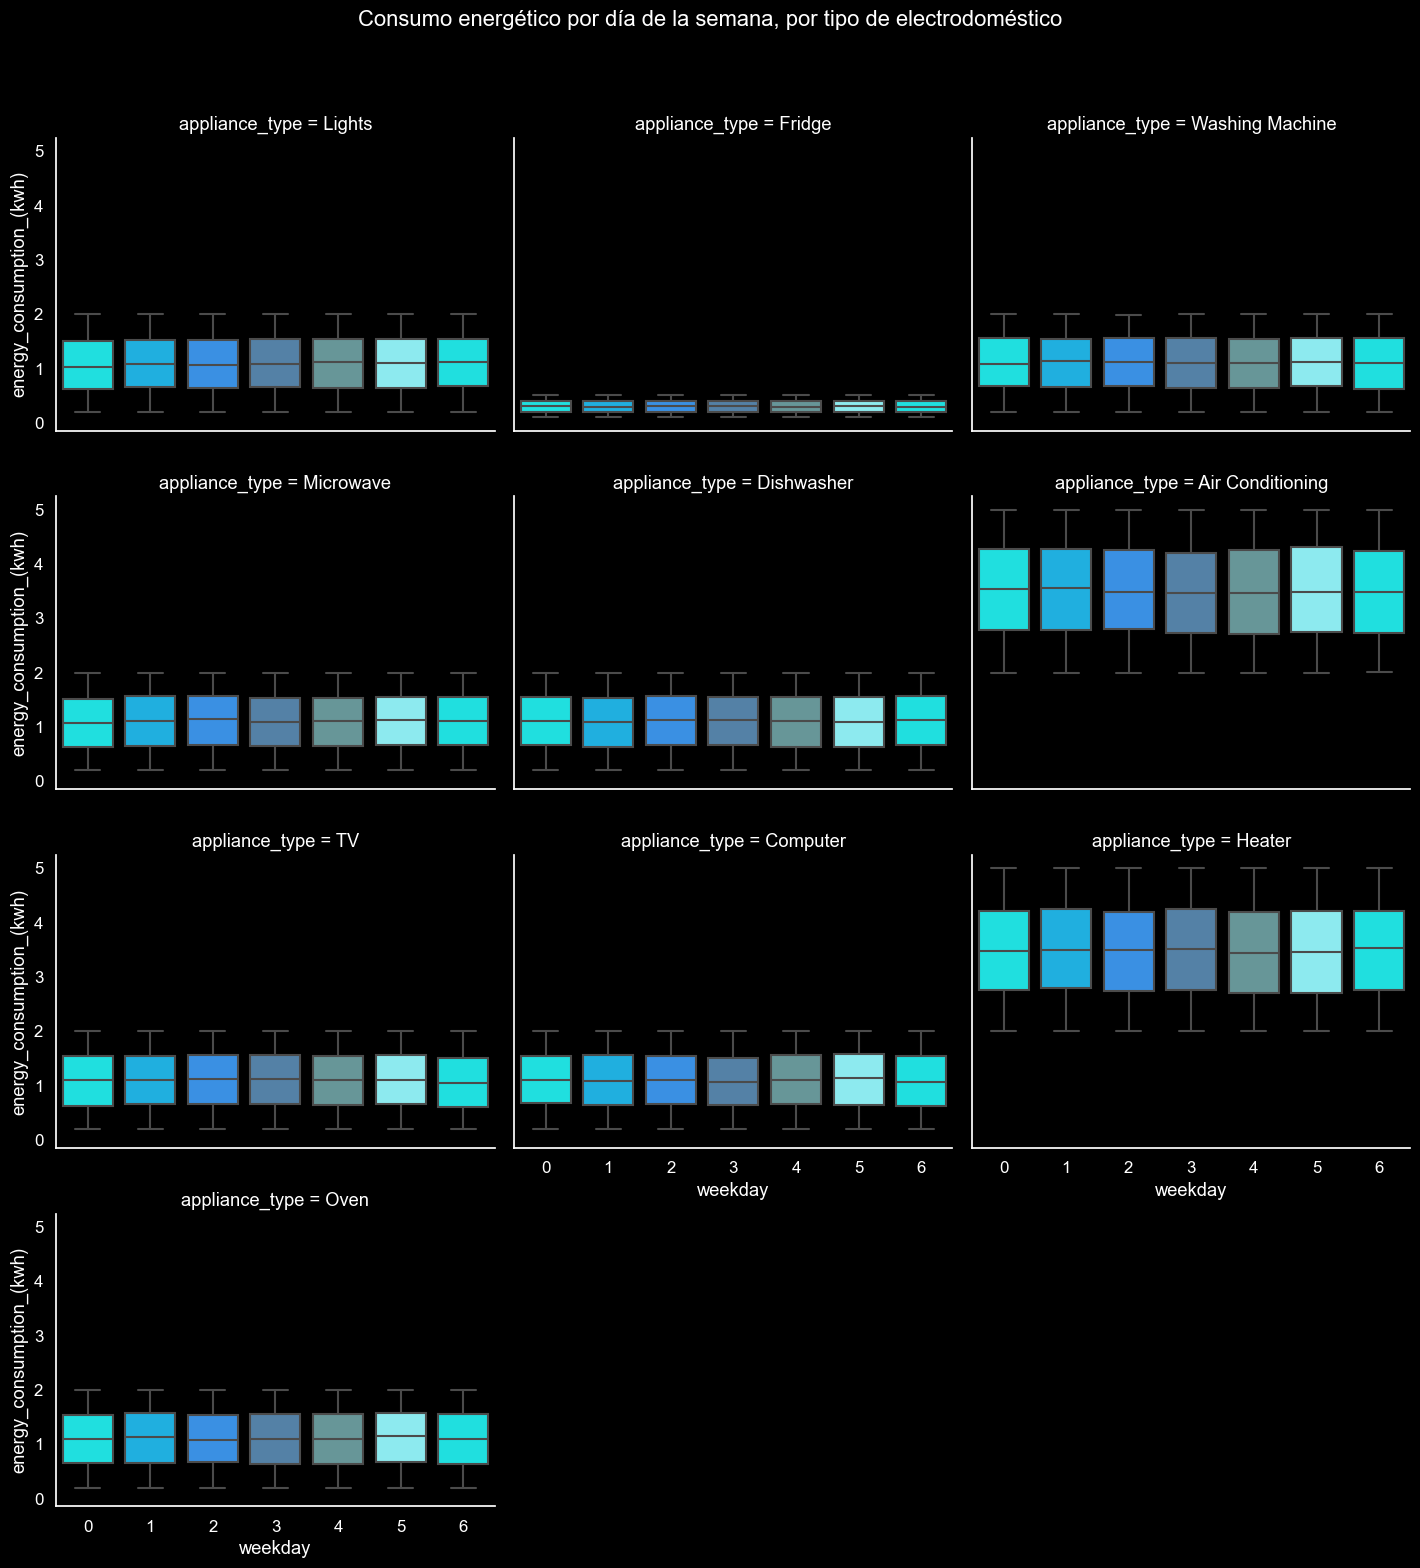

appliance_type
Air Conditioning   -0.018612
Computer           -0.006364
Dishwasher          0.003124
Fridge             -0.003711
Heater             -0.001484
Lights              0.020540
Microwave           0.010253
Oven                0.003305
TV                 -0.013974
Washing Machine    -0.004189
dtype: float64


In [11]:
# Análisis por día de la semana
show_catplot(df, x="weekday", title="Consumo energético por día de la semana, por tipo de electrodoméstico")

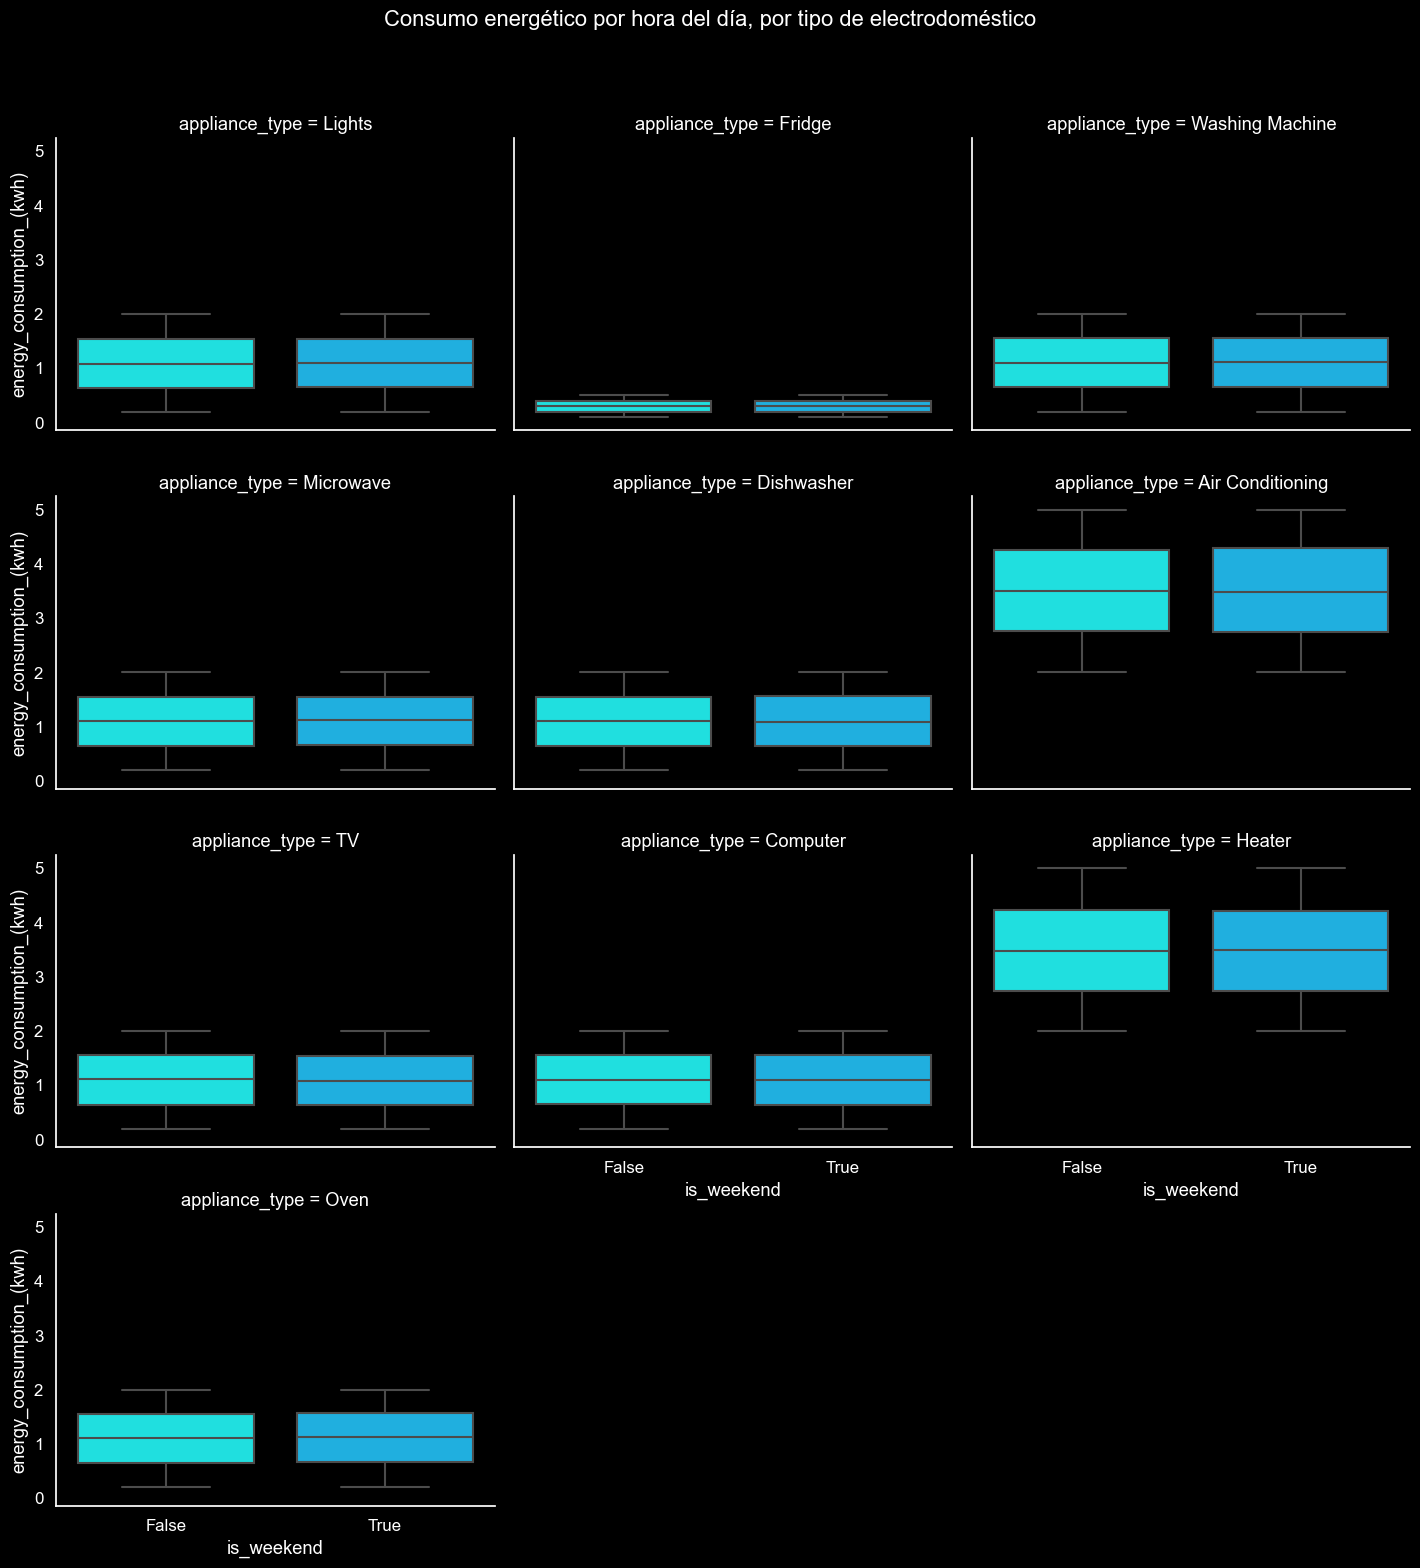

appliance_type
Air Conditioning   -0.004430
Computer           -0.002305
Dishwasher          0.000631
Fridge              0.002415
Heater              0.003611
Lights              0.013372
Microwave           0.004852
Oven                0.009528
TV                 -0.018673
Washing Machine     0.000522
dtype: float64


In [12]:
# Análisis por fín de semana
show_catplot(df, x="is_weekend")

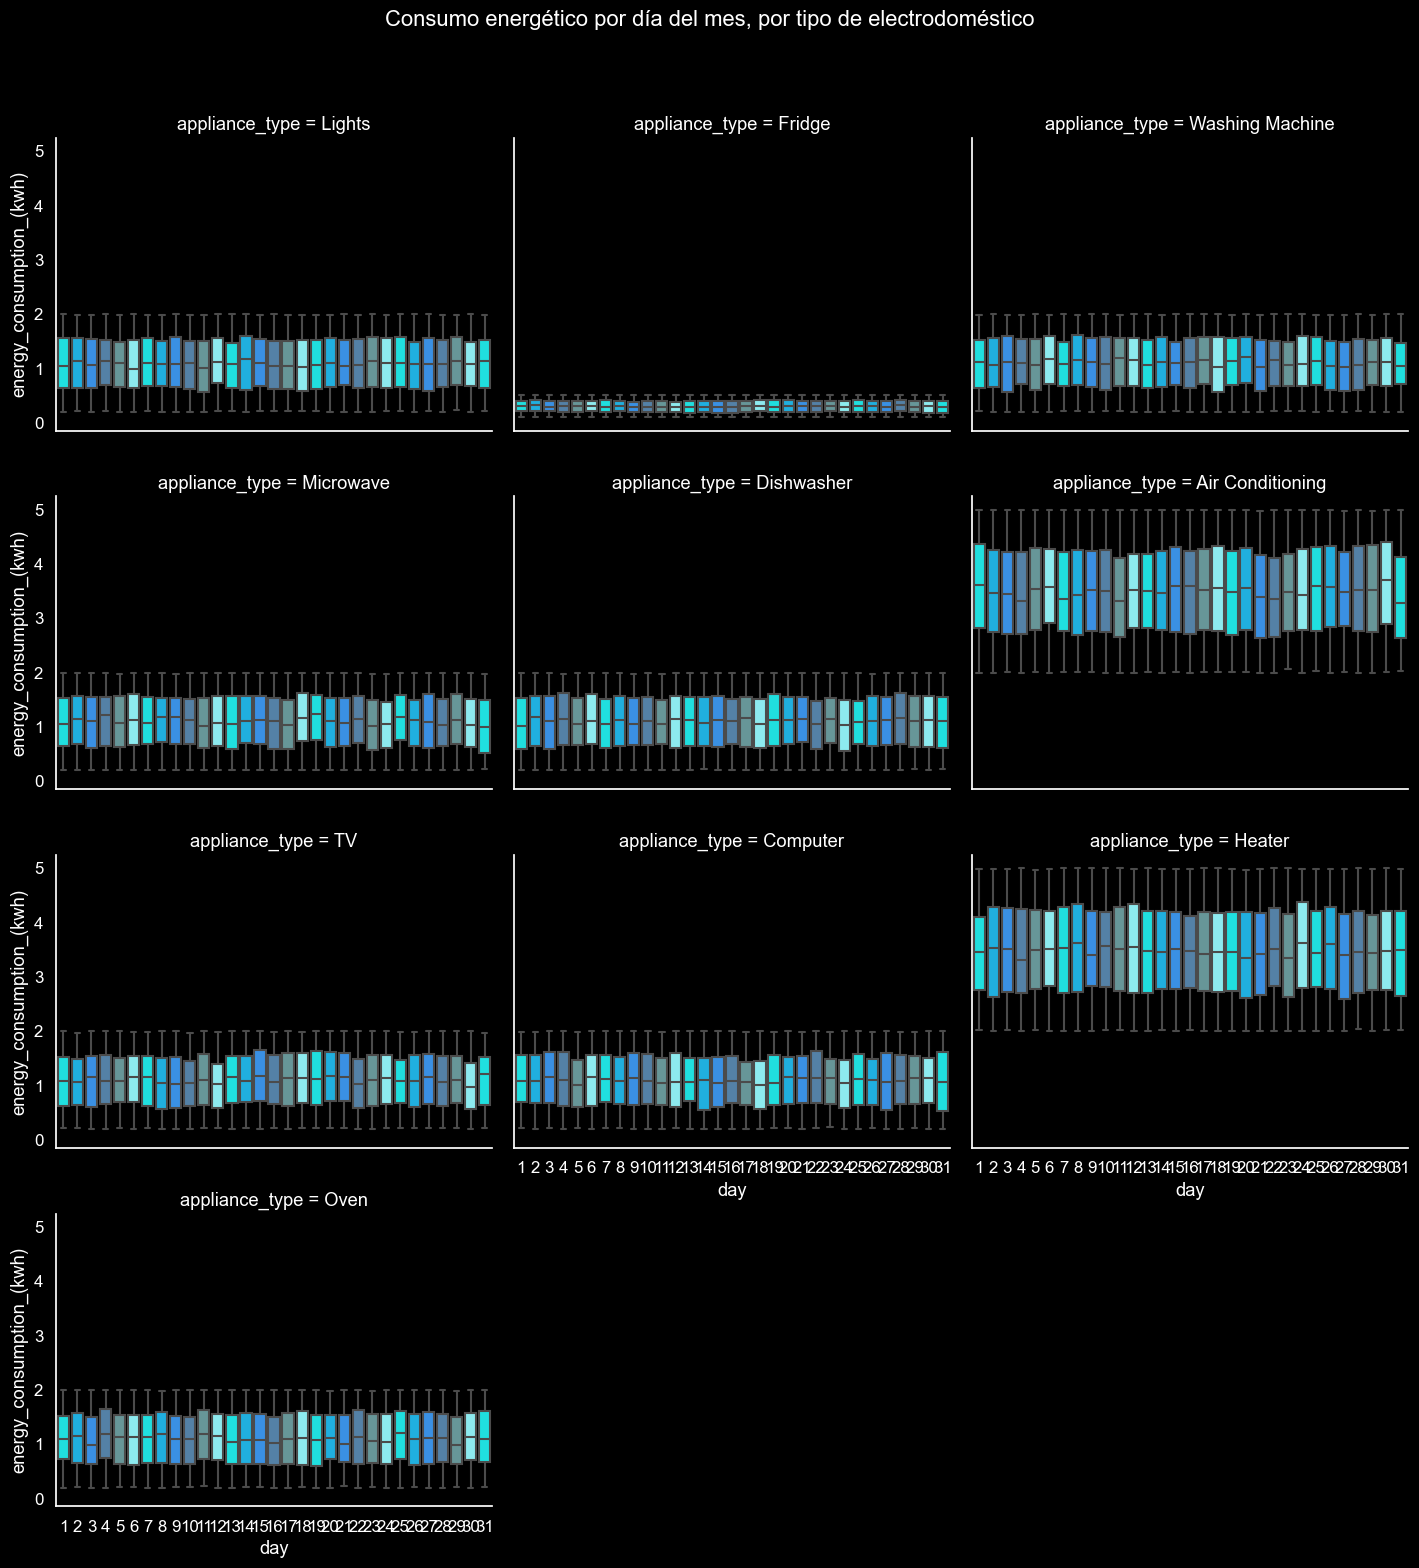

appliance_type
Air Conditioning    0.007255
Computer           -0.010225
Dishwasher          0.004152
Fridge              0.003709
Heater             -0.008496
Lights              0.005282
Microwave          -0.009724
Oven               -0.006684
TV                  0.008391
Washing Machine    -0.008887
dtype: float64


In [13]:
# Análisis por día del mes
show_catplot(df, x="day", title="Consumo energético por día del mes, por tipo de electrodoméstico")

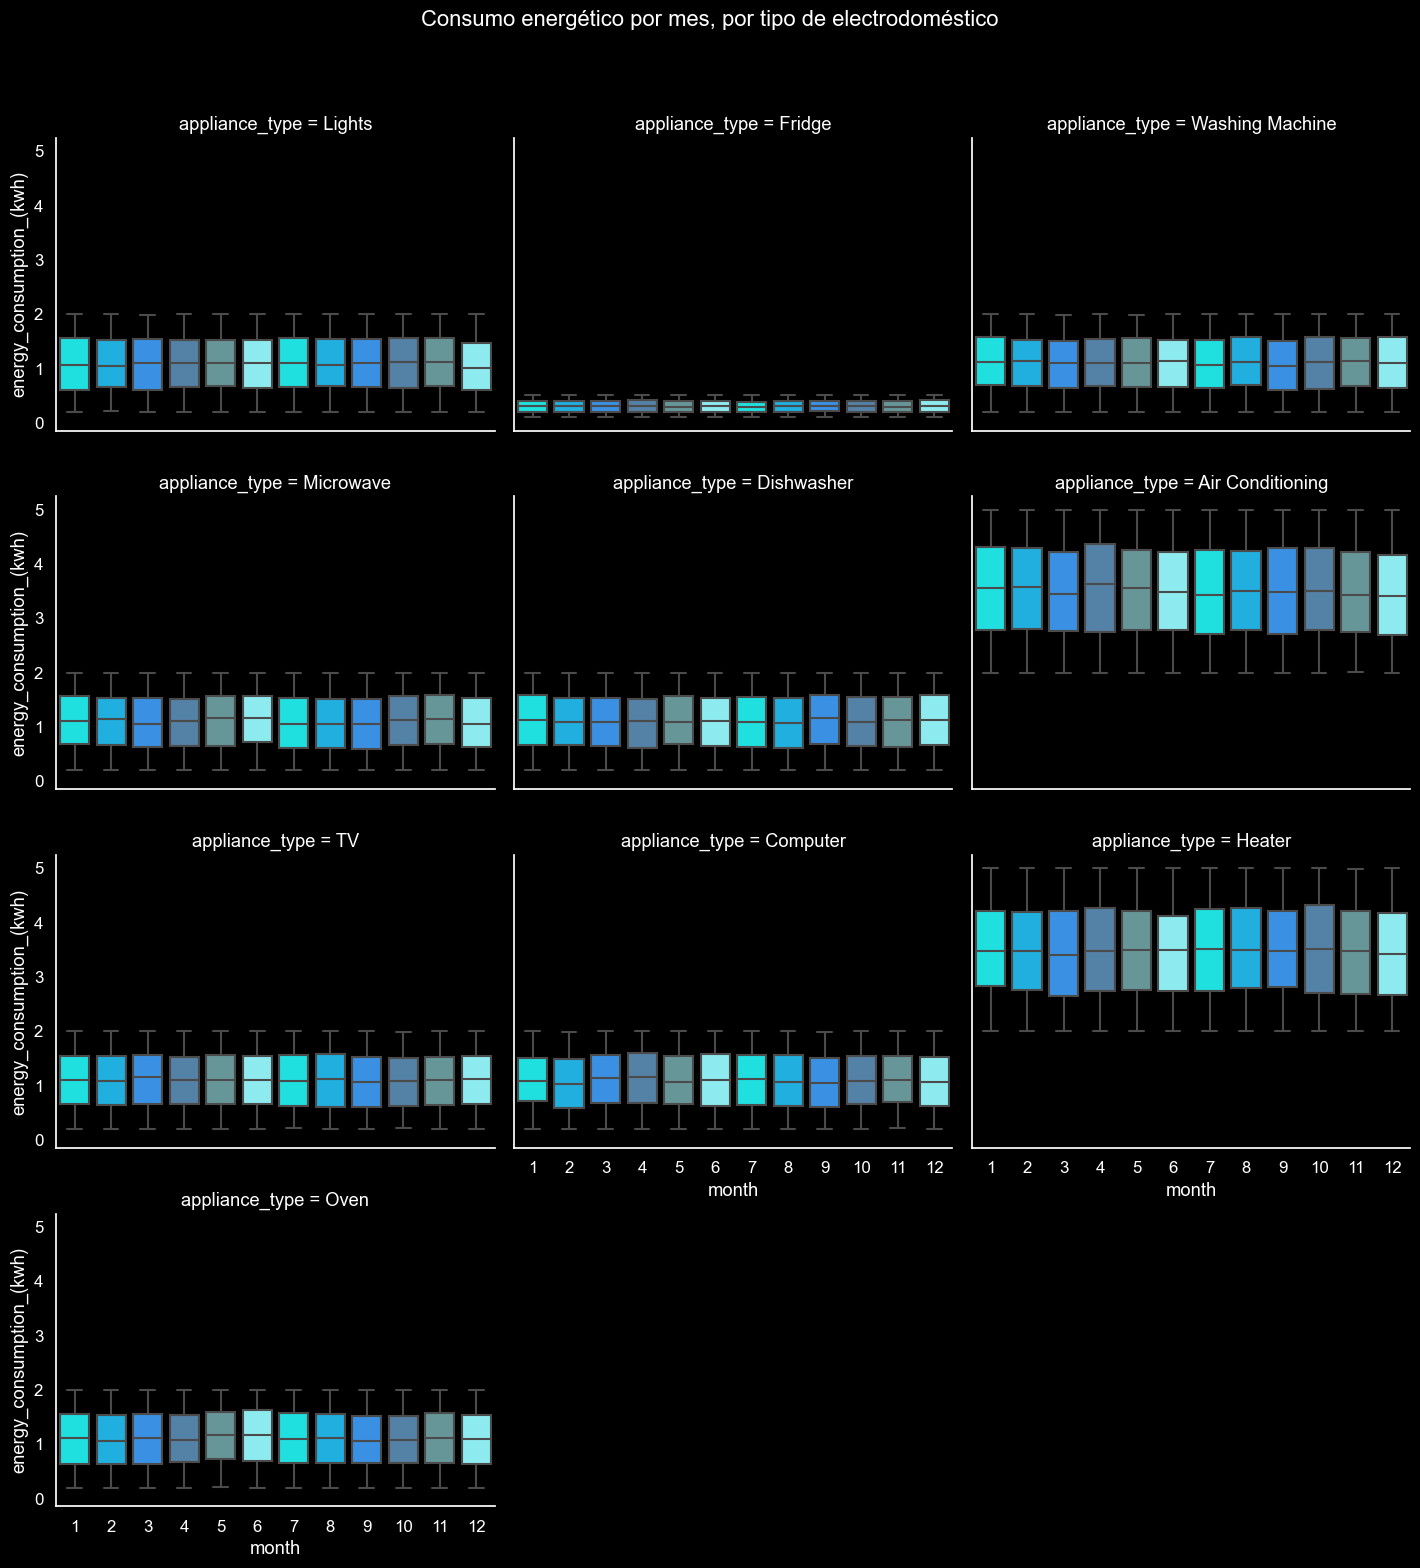

appliance_type
Air Conditioning   -0.028424
Computer           -0.003251
Dishwasher          0.003282
Fridge             -0.003003
Heater              0.000657
Lights              0.002636
Microwave          -0.002491
Oven               -0.007449
TV                 -0.009618
Washing Machine    -0.007048
dtype: float64


In [14]:
# Análisis por mes
show_catplot(df, x="month", title="Consumo energético por mes, por tipo de electrodoméstico")

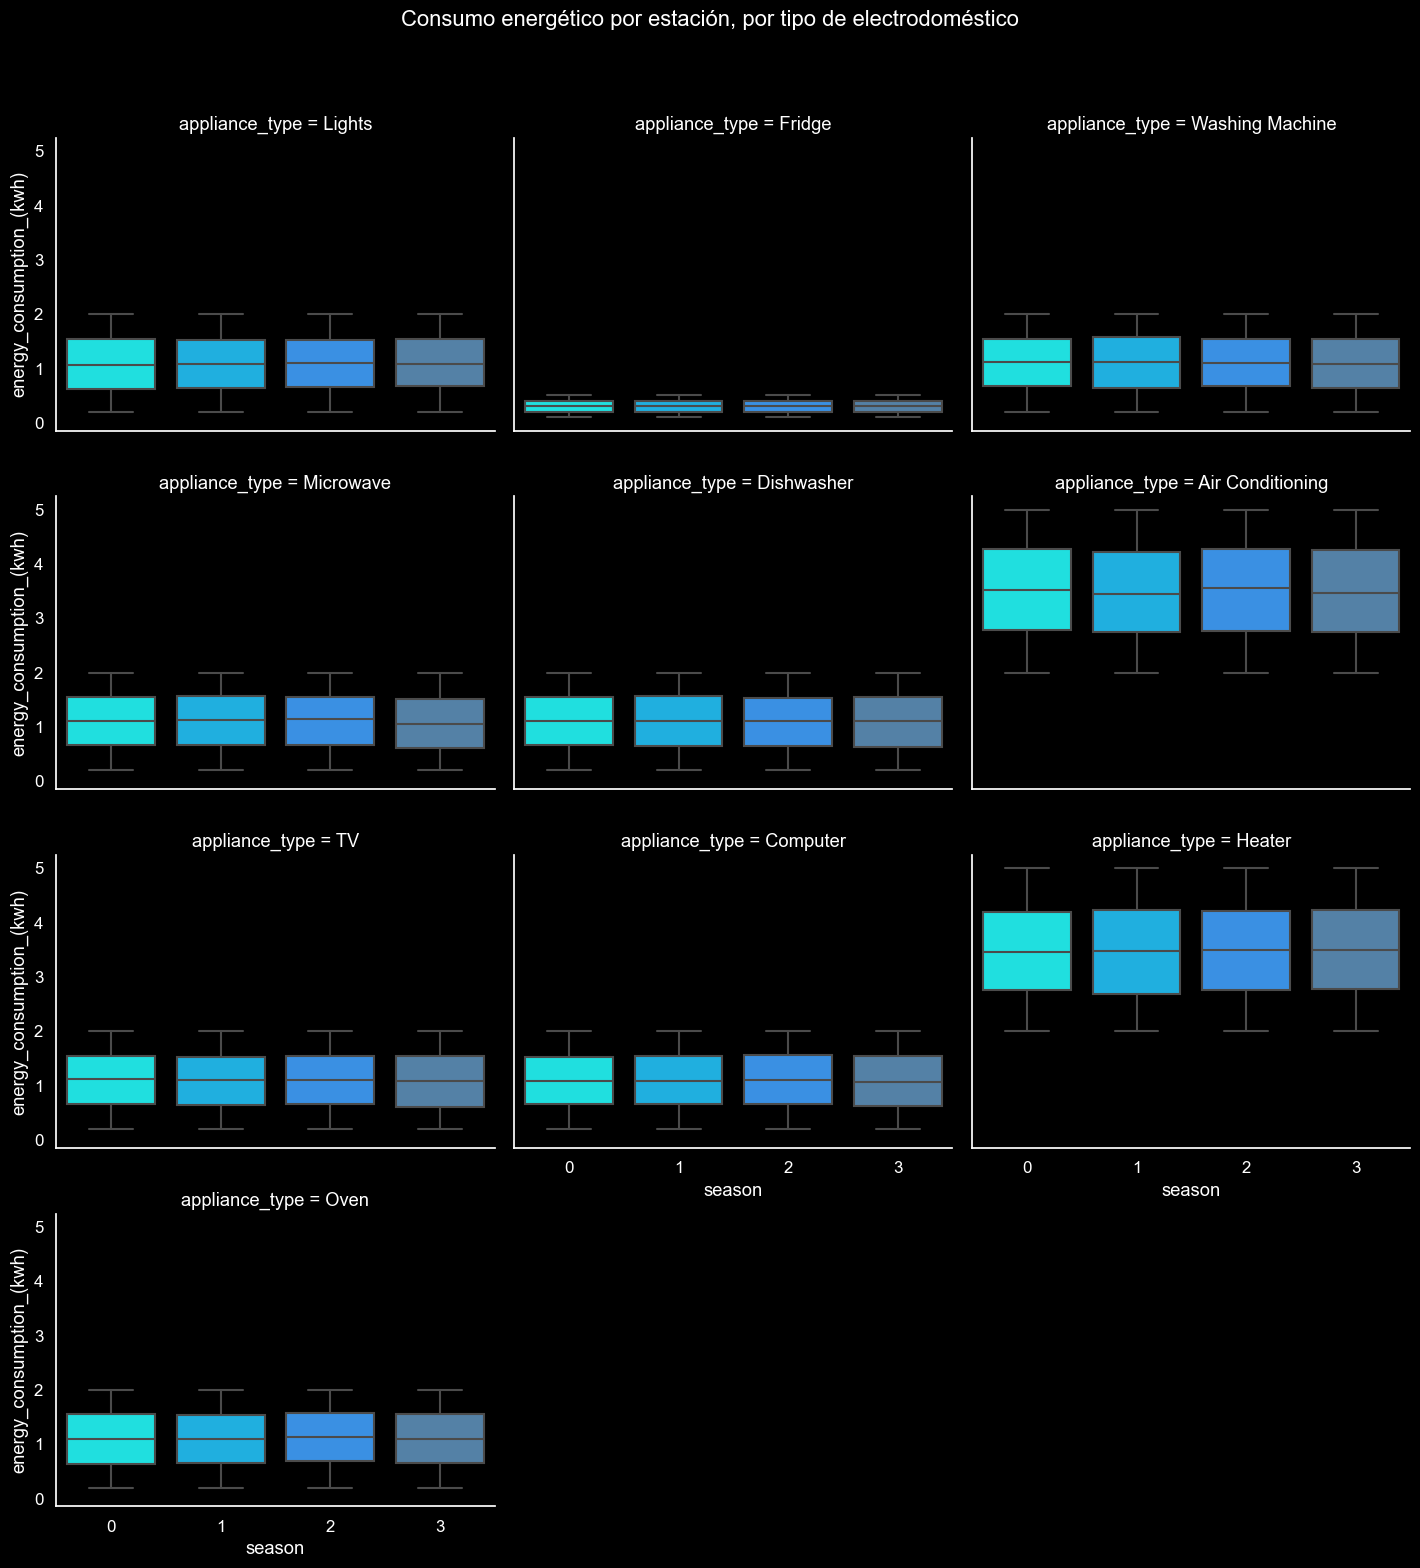

appliance_type
Air Conditioning   -0.003737
Computer           -0.004653
Dishwasher         -0.003178
Fridge             -0.006478
Heater              0.016258
Lights              0.016553
Microwave          -0.017271
Oven                0.006670
TV                 -0.005748
Washing Machine    -0.013581
dtype: float64


In [15]:
# Análisis por estación
show_catplot(df, x="season", title="Consumo energético por estación, por tipo de electrodoméstico")

### Análisis por temperatura

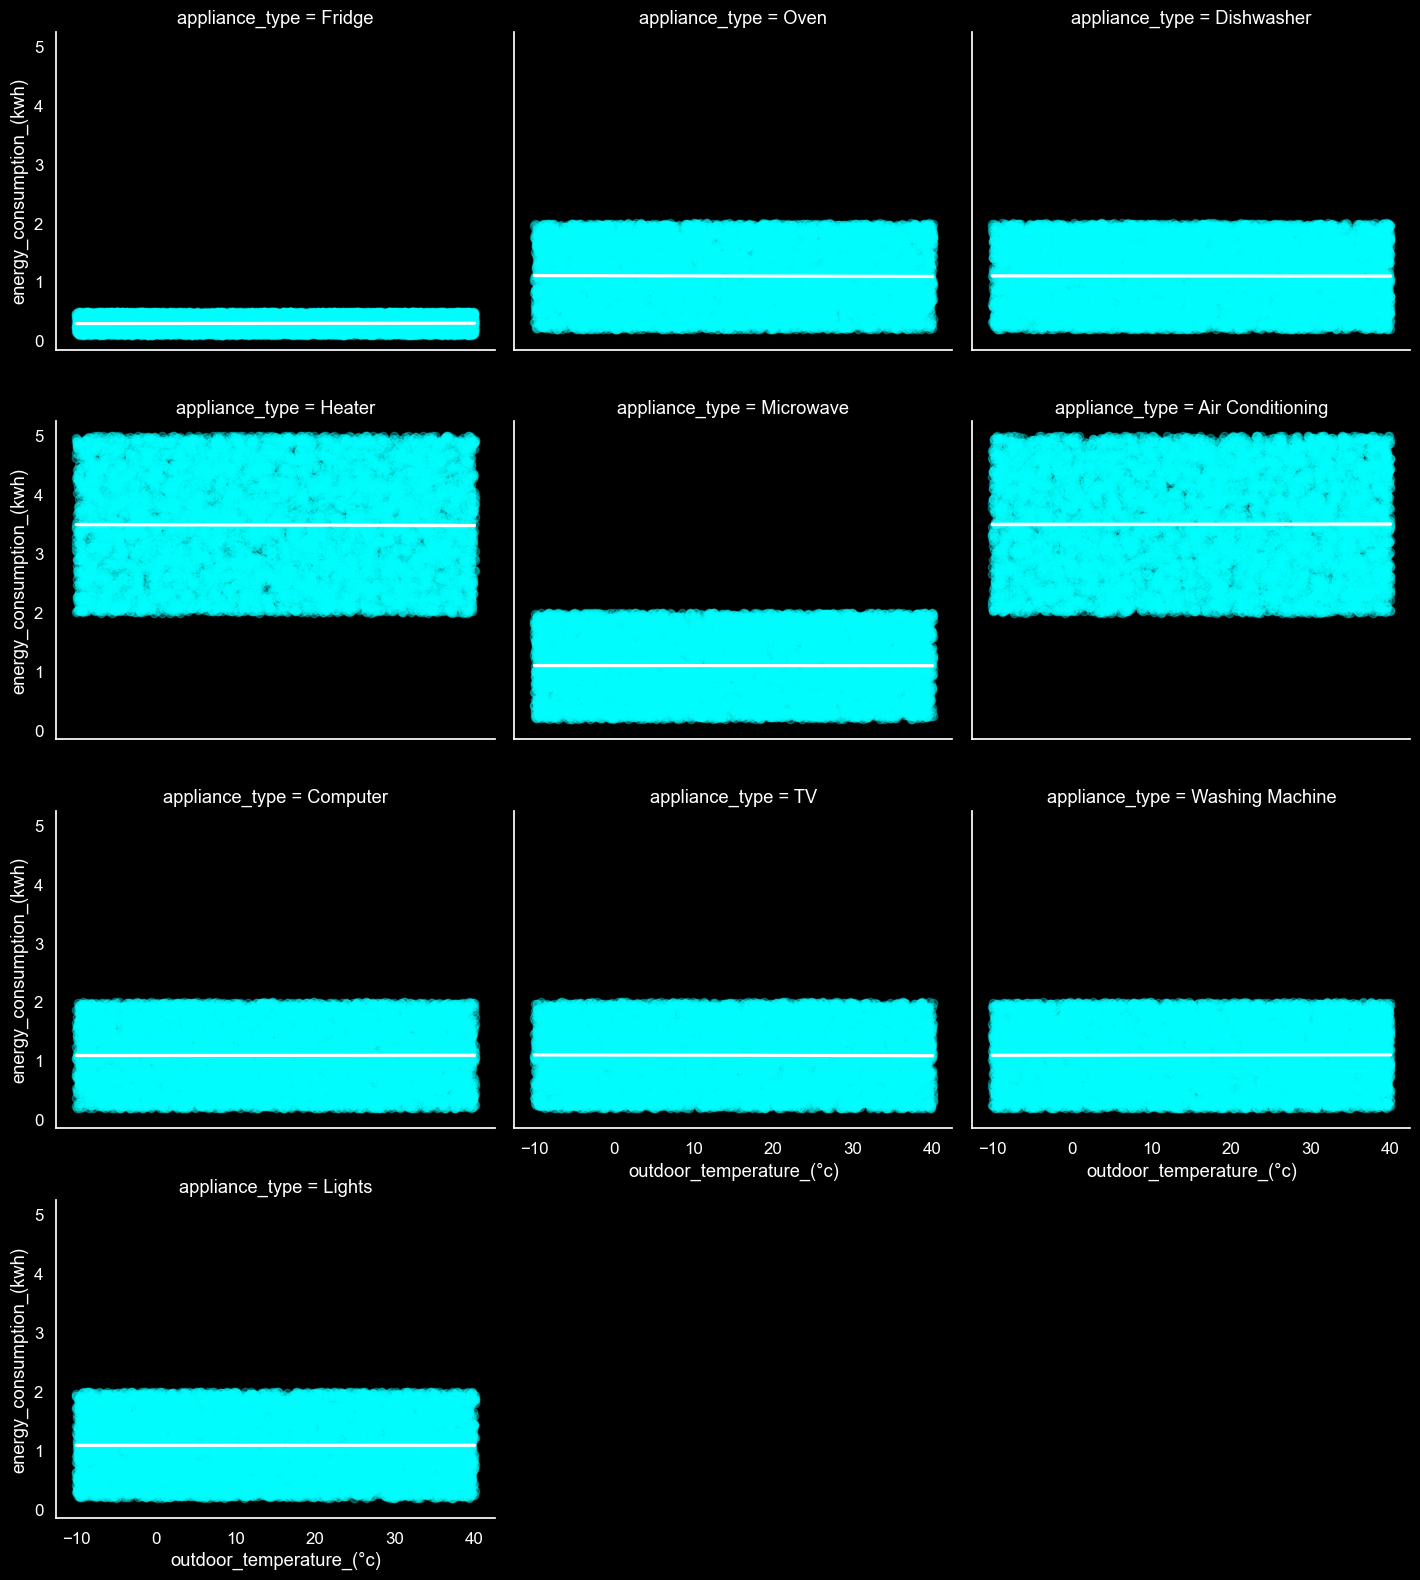

In [16]:
sns.lmplot(
    data=df,
    x="outdoor_temperature_(°c)",
    y="energy_consumption_(kwh)",
    col="appliance_type",
    col_wrap=3,                    # número de gráficos por fila
    height=4,
    aspect=1.2,
    scatter_kws={"alpha": 0.3, "color": "cyan"},
    line_kws={"color": "white"}
)

In [17]:
correlations = (
    df.groupby("appliance_type")
      .apply(lambda g: g["outdoor_temperature_(°c)"].corr(g["energy_consumption_(kwh)"]))
)

# Mostrar
print(correlations)

appliance_type
Air Conditioning    0.001909
Computer            0.001539
Dishwasher         -0.002496
Fridge              0.015440
Heater             -0.005666
Lights              0.000389
Microwave          -0.001256
Oven               -0.008528
TV                 -0.007381
Washing Machine     0.005434
dtype: float64


### Análisis por número de personas

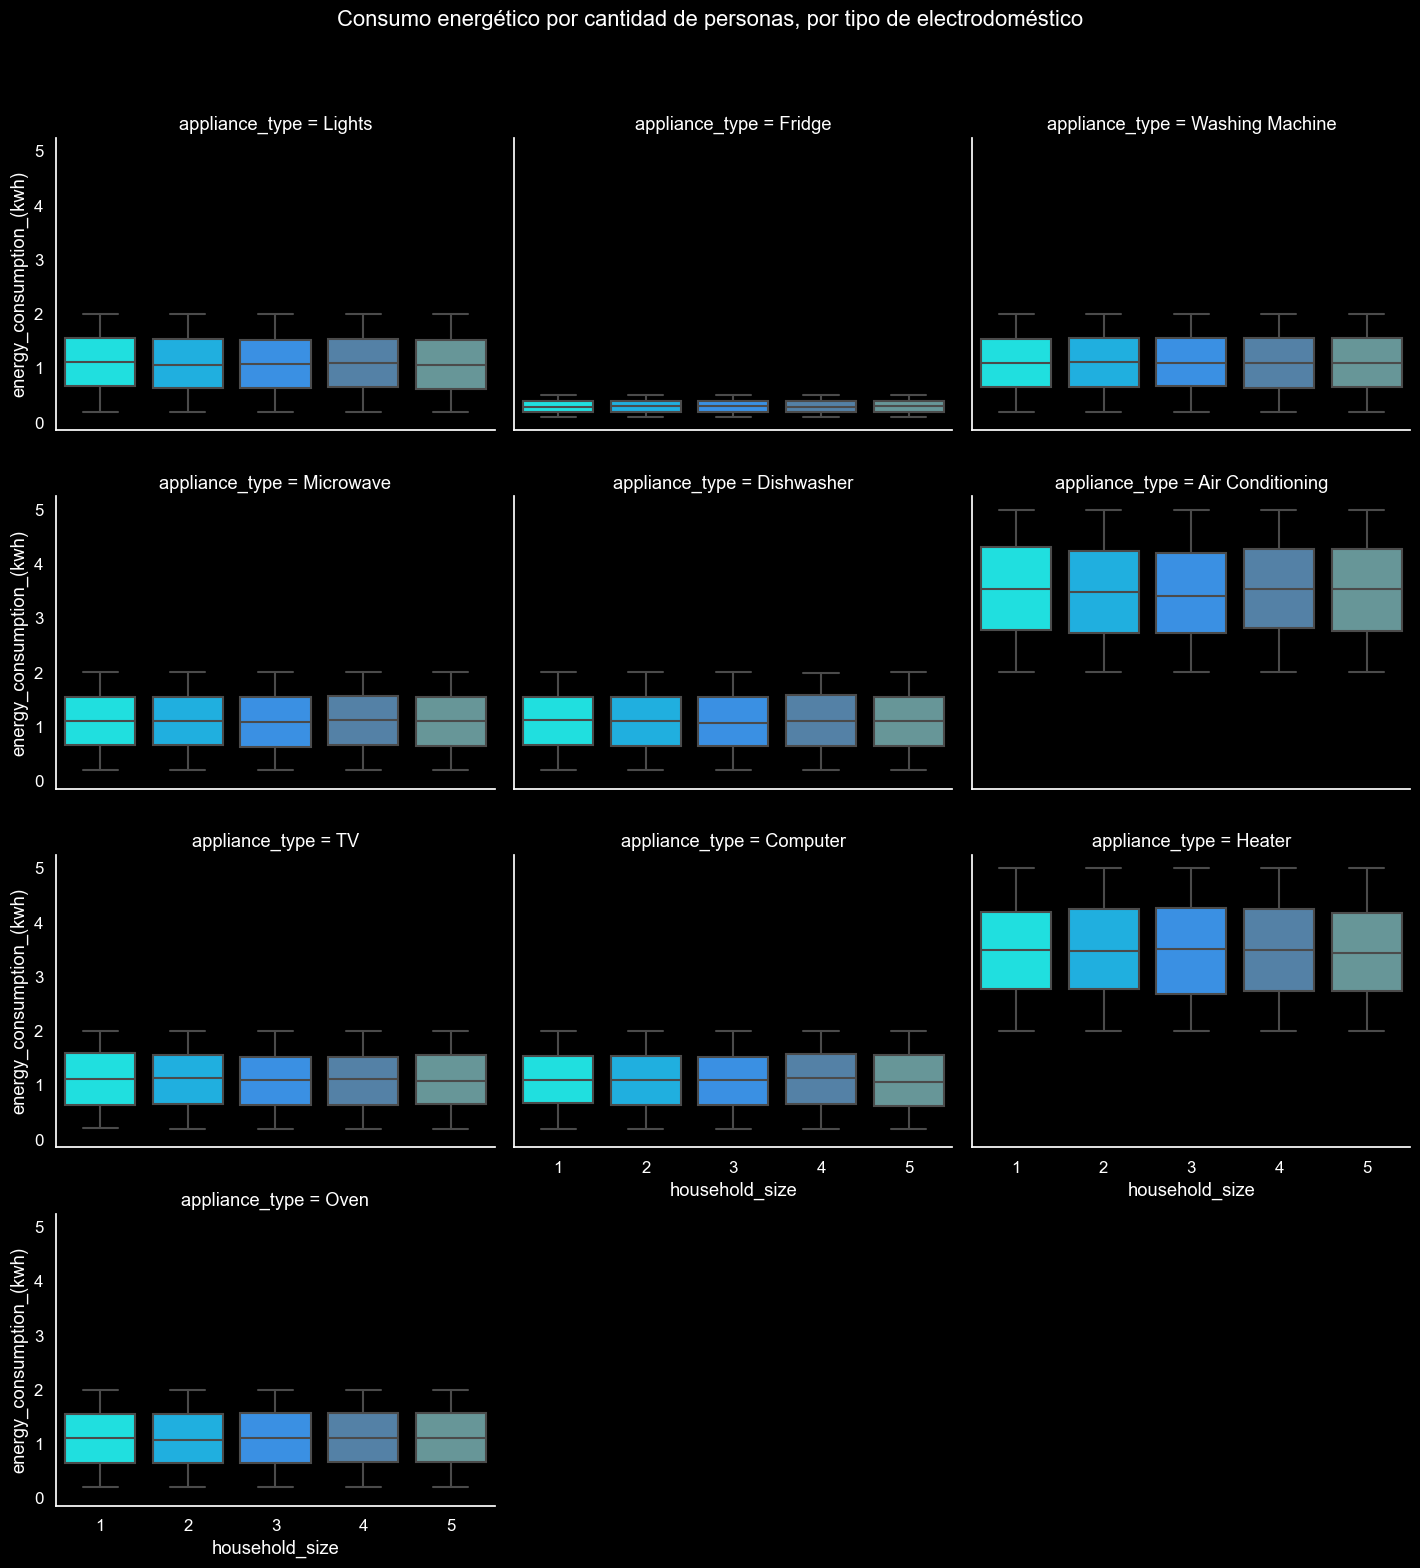

appliance_type
Air Conditioning    0.001867
Computer           -0.006379
Dishwasher         -0.007996
Fridge              0.001233
Heater             -0.012553
Lights             -0.019277
Microwave          -0.006504
Oven                0.007296
TV                 -0.009925
Washing Machine    -0.003929
dtype: float64


In [18]:
show_catplot(df, x="household_size", title="Consumo energético por cantidad de personas, por tipo de electrodoméstico")

## Limpieza preliminar final

In [19]:
df.drop(columns=['hour', 'weekday', 'day', 'month'], inplace=True)
df.head()

,home_id,appliance_type,energy_consumption_(kwh),outdoor_temperature_(°c),season,household_size,datetime,is_weekend
0,94,Fridge,0.20,-1.0,1,2,2023-12-02 21:12:00,True
1,435,Oven,0.23,31.1,3,5,2023-08-06 20:11:00,True
2,466,Dishwasher,0.32,21.3,1,3,2023-11-21 06:39:00,False
3,496,Heater,3.92,-4.2,0,1,2023-01-21 21:56:00,True
4,137,Microwave,0.44,34.5,3,5,2023-08-26 04:31:00,True


In [20]:
# Guardar
processed_path = os.path.join(config["paths"]["processed_data"], 'eda_processed_data.csv')
os.makedirs(os.path.dirname(processed_path), exist_ok=True)
df.to_csv(processed_path, index=False)

print(f"✅ Datos procesados guardados en {processed_path}")

✅ Datos procesados guardados en data/processed/eda_processed_data.csv
